In [2]:
PROC_TRAIN_DATA_PATH = "../../data/processed/preprocessed_train_data.pkl"
CLEANED_TEST_DATA_PATH = "../../data/interim/cleaned_test_data.pkl"


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Import estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from genetic_selection import GeneticSelectionCV

# Import metrics
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
)
from yellowbrick.classifier import ClassificationReport


# Import features selection methods
from sklearn.feature_selection import (
    SelectFromModel,
)

# Import tunning hypter parameters methods
from sklearn.model_selection import GridSearchCV

# Import resambling methods
from imblearn.over_sampling import SMOTE, SMOTENC, RandomOverSampler
from imblearn.pipeline import Pipeline

import warnings

warnings.filterwarnings("ignore")


In [4]:
# Change some pandas display options
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_colwidth", 0)
pd.set_option("display.width", 1000)
pd.set_option("styler.format.precision", 10)


# Read Data


In [5]:
df_train = pd.read_pickle(PROC_TRAIN_DATA_PATH)
df_test = pd.read_pickle(CLEANED_TEST_DATA_PATH)

num_cols = [
    "age",
    "resting_blood_pressure",
    "serum_cholestoral",
    "maximum_heart_rate",
    "ST_depression",
]
cat_cols = set(df_train.columns.to_list()) - set(num_cols)
cat_cols = list(cat_cols)

X = df_train.iloc[:, :-1]
y = df_train["target"]


# Grid Search


In [24]:
pipe = Pipeline(
    [
        (
            "reduce_dim",
            "passthrough",
        ),  # the reduce_dim stage is populated by the param_grid
        ("ros_resambling", RandomOverSampler()),
        # ("smote_resampling", SMOTE(random_state=42)),
        ("estimator", RandomForestClassifier()),
    ]
)

N_FEATURES_OPTIONS = [6, 7, 8, 9]
N_NEIGHBORS_OPTIONS = [3, 5, 7]
N_TREES_OPTIONS = [60, 80, 100, 120]
TREE_CRITERION = ["gini", "entropy"]

genetic_params = dict(
    estimator=DecisionTreeClassifier(),
    cv=5,
    scoring="precision_weighted",
    n_population=50,
    crossover_proba=0.5,
    mutation_proba=0.2,
    n_generations=100,
    crossover_independent_proba=0.5,
    mutation_independent_proba=0.04,
    tournament_size=3,
    n_gen_no_change=10,
)

param_grid = [
    {
        "reduce_dim": [SelectFromModel(DecisionTreeClassifier(criterion="gini"))],
        "reduce_dim__max_features": N_FEATURES_OPTIONS,
        "reduce_dim__estimator__criterion": TREE_CRITERION,
        # "smote_resampling__k_neighbors": N_NEIGHBORS_OPTIONS,
        "estimator__n_estimators": N_TREES_OPTIONS,
    },
    {
        "reduce_dim": [GeneticSelectionCV(**genetic_params)],
        # "reduce_dim__k": N_FEATURES_OPTIONS,
        # "reduce_dim__score_func__n_neighbors": N_NEIGHBORS_OPTIONS,
        # "smote_resampling__k_neighbors": N_NEIGHBORS_OPTIONS,
        "estimator__n_estimators": N_TREES_OPTIONS,
    },
]
reducer_labels = ["PCA", "NMF", "KBest(mutual_info_classif)"]

scoring = {
    "accuracy": "accuracy",
    "f1": "f1_weighted",
    "ROC_AUC": "roc_auc_ovo_weighted",
}

grid = GridSearchCV(
    pipe,
    n_jobs=-1,
    param_grid=param_grid,
    scoring=scoring,
    refit="f1",
    verbose=2,
    return_train_score=True,
)
grid.fit(X, y)


Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(estimator=Pipeline(steps=[('reduce_dim', 'passthrough'),
                                       ('ros_resambling', RandomOverSampler()),
                                       ('estimator',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'estimator__n_estimators': [60, 80, 100, 120],
                          'reduce_dim': [SelectFromModel(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                         max_features=6)],
                          'reduce_dim__estimator__criterion': [...
                          'reduce_dim': [GeneticSelectionCV(crossover_independent_proba=0.5,
                                                            cv=5,
                                                            estimator=DecisionTreeClassifier(),
                                                            mutation_independent_proba=0.04,
                                                            n_gen_no_change=10,
                                                            n_generations=100,
                                                            n_population=50,
                                                            scoring='precision_weighted')]}],
             refit='f1', return_train_score=True,
             scoring={'ROC_AUC': 'roc_auc_ovo_weighted', 'accuracy': 'accuracy',
                      'f1': 'f1_weighted'},
             verbose=2)

In [25]:
grid.best_estimator_


Pipeline(steps=[('reduce_dim',
                 SelectFromModel(estimator=DecisionTreeClassifier(criterion='entropy'),
                                 max_features=6)),
                ('ros_resambling', RandomOverSampler()),
                ('estimator', RandomForestClassifier(n_estimators=60))])

In [26]:
grid.best_score_


0.5613554228835228

In [9]:
selected_columns_mask = grid.best_estimator_.named_steps["reduce_dim"].get_support()
selected_features = X.columns[selected_columns_mask]
selected_features


Index(['age', 'chest_pain_type', 'serum_cholestoral', 'maximum_heart_rate', 'ST_depression', 'number_of_major_vessels', 'thallium_stress_result'], dtype='object')

In [10]:
results = grid.cv_results_


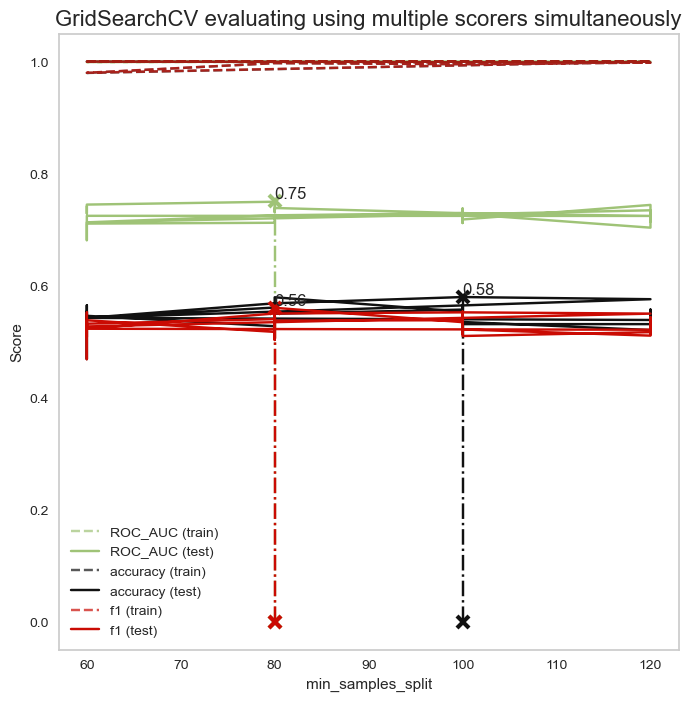

In [17]:
plt.figure(figsize=(8, 8))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("min_samples_split")
plt.ylabel("Score")

ax = plt.gca()
# ax.set_xlim(0, 402)
# ax.set_ylim(-1, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(grid.cv_results_["param_estimator__n_estimators"].data, dtype=float)


# Iterate over each scorer
for scorer, color in zip(sorted(scoring), ["g", "k", "r"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results["std_%s_%s" % (sample, scorer)]
        # ax.fill_between(
        #     X_axis,
        #     sample_score_mean - sample_score_std,
        #     sample_score_mean + sample_score_std,
        #     alpha=0.1 if sample == "test" else 0,
        #     color=color,
        # )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)


# Testing


- If you care about the performance of each class equally, regardless of their frequency, use **macro-averaged precision**.
- If you care about the overall performance of the classifier, regardless of the class distribution, use **micro-averaged precision**.
- If you care about the performance of each class proportionally to their frequency, use **weighted-averaged precision**.


In [12]:
X_test = df_test.iloc[:, :-1]
y_test = df_test["target"]


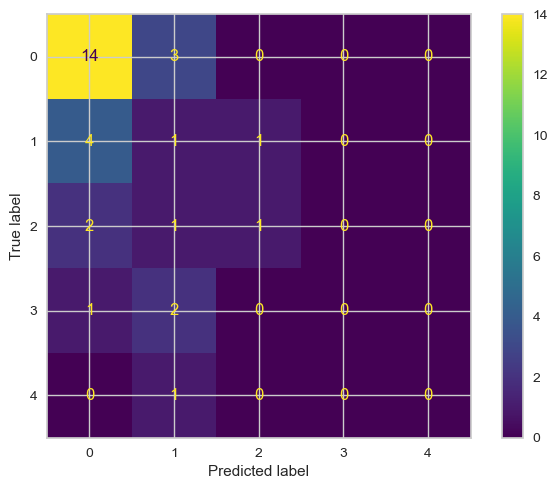

In [13]:
y_pred = grid.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()


In [14]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.67      0.82      0.74        17
           1       0.12      0.17      0.14         6
           2       0.50      0.25      0.33         4
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         1

    accuracy                           0.52        31
   macro avg       0.26      0.25      0.24        31
weighted avg       0.45      0.52      0.47        31



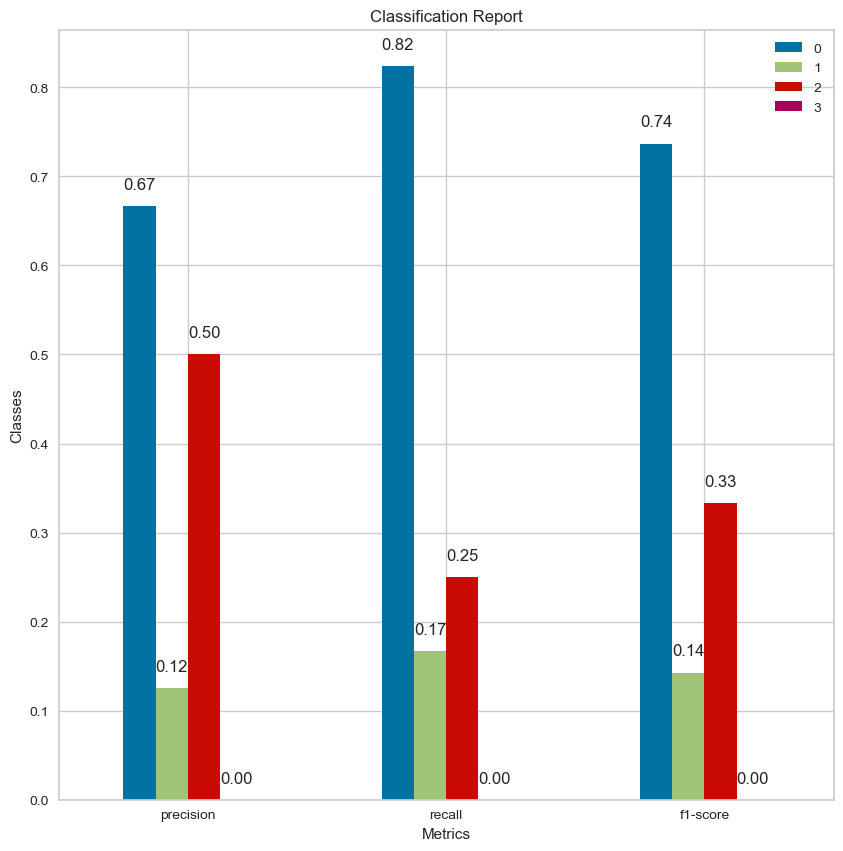

In [23]:
def plot_classification_report():
    report = classification_report(y_test, y_pred, output_dict=True)

    # convert the report to a dataframe
    report_df = pd.DataFrame(report)

    # plot the heatmap of the metrics
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot()
    report_df.iloc[:3, :4].plot(kind="bar", ax=ax)
    ax.margins(0.1, None)
    ax.set_title("Classification Report")
    ax.set_xlabel("Metrics")
    ax.set_ylabel("Classes")
    ax.tick_params(axis="x", rotation=0)
    for container in ax.containers:
        ax.bar_label(container, fmt="%0.2f", fontsize=12, padding=10)


plot_classification_report()
